In [1]:
#############################################
## Created on October 2024
##
## Author: Valentina Di Marco
##
## Toy model 
##############################################

import numpy as np
import matplotlib.pyplot as plt
import bilby
import inspect

In [5]:
#seed = 42

#define parameters for function FRED
Delta = 0.4 # time delay
A = 2 # this scales the function
xi = 1 # asimmmetry parameter
tau = 0.20 # duration scaling parameter
gamma = 2.5 # exponent for flatter/sharper peak
nu = 1 # exponent for flatter/sharper peak
sigma = 0.02

samples = 1000  # number of samples

phi = np.arange(0, 1, 1/samples)  # phase values
noise = np.random.normal(loc=0, scale=sigma, size=phi.shape)  # white noise

num_in_group = 1 # the number of profiles in a group

In [6]:
# define FRED function to generate the data
def fred(A, xi, phi, Delta, tau):
    shifted_phi = phi - Delta # apply phase shift and Delta
    shifted_phi = np.where(np.abs(shifted_phi) < 1e-10, 1e-10, shifted_phi)  # avoid division by zero
    term_1 = shifted_phi / tau  # first term in the exponent
    term_2 = tau / shifted_phi  # second term in the exponent
    exponent = -xi**gamma * (term_1**gamma + term_2**nu)  # full exponent
    FRED = A * np.exp(exponent)  # FRED function result
    FRED_cleaned = np.nan_to_num(FRED, nan=0.0)  # remove NaNs
    return FRED_cleaned # add white noise

# this function phase shifts the data
def shift_data(data, delta_phi):
    # Apply phase shift
    data_f = np.fft.fft(data)
    n = len(data)
    frequencies = np.fft.fftfreq(n)
    data_f_shifted = data_f * np.exp(2j * np.pi * frequencies * delta_phi*samples)
    data_t_shifted = np.fft.ifft(data_f_shifted)

    return data_t_shifted

# define a function to generate data (shifted data with white noise)
def generate_data(A, xi, phi, Delta, tau, samples):
    data = []
    for i in range(num_in_group):
        # generate the FRED function
        fred_t = fred(A, xi, phi, Delta, tau)
        # shift the FRED function
        phase_shift = np.random.uniform(0, 1)
        print("phase shift")
        print(phase_shift)
        fred_t_shifted = shift_data(fred_t, phase_shift)
        # add white noise
        profile =  fred_t_shifted + noise
        data.append(profile)
    return np.real(data)

def template_function(phi, delta_phi):
    # Apply phase shift
    data_t_shifted = shift_data(data[0], delta_phi)

    # Apply DM
    #this is where we will write the code to apply the DM

    return np.real(data_t_shifted)

phase shift
0.07906362836218184
phase shift
0.39227703464857433
****** data has been created ********


/var/folders/zw/_vyj75_j6lxgkjp7g_2gwdl9zjbgt4/T/ipykernel_50048/2610468065.py:7: RuntimeWarning: invalid value encountered in power
  exponent = -xi**gamma * (term_1**gamma + term_2**nu)  # full exponent


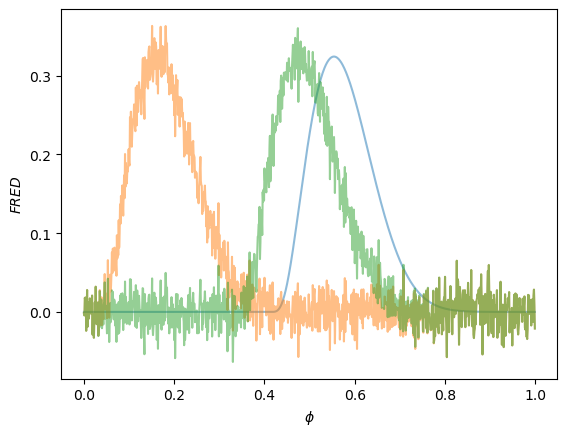

In [14]:
# generate portraits
data_base = generate_data(A, xi, phi, Delta, tau, samples)
data = generate_data(A, xi, phi, Delta, tau, samples)
fred_t = fred(A, xi, phi, Delta, tau)

# plot the data
plt.plot(phi, fred_t, label='FRED', alpha=0.5)
for i in range(num_in_group):
    plt.plot(phi, data[i], alpha=0.5)
plt.plot(phi, data_base[0], alpha=0.5)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$FRED$')

plt.savefig(f'FRED.png')

print("****** data has been created ********")

In [21]:
# Initialize the grid with priors and likelihood
priors = {
    #'A': bilby.core.prior.Uniform(0.1, 10, 'A'),
    **{'delta_phi': bilby.core.prior.Uniform(0, 1, 'delta_phi', boundary="periodic") for i in range(num_in_group)}
    #**{'delta_phi': bilby.core.prior.Uniform(0, 1, 'delta_phi') for i in range(num_in_group)}
    #'DM': bilby.core.prior.Uniform(0, 100, 'DM'),
}
priors ['sigma'] = bilby.core.prior.Uniform(0.01, 0.03)


print("Priors:")
priors

Priors:


{'delta_phi': Uniform(minimum=0, maximum=1, name='delta_phi', latex_label='delta_phi', unit=None, boundary='periodic'),
 'sigma': Uniform(minimum=0.01, maximum=0.03, name=None, latex_label=None, unit=None, boundary=None)}

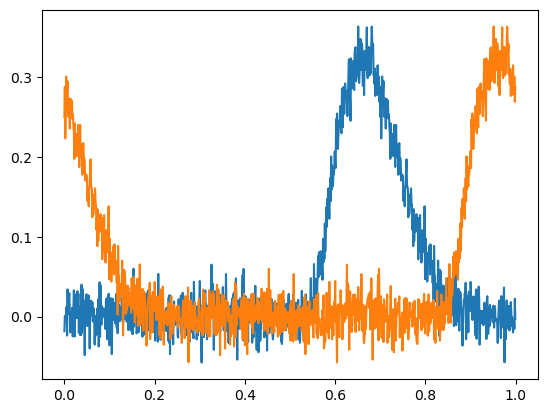

In [22]:
# testing the template function
v = template_function(phi, 0.1)
plt.plot(phi, template_function(phi, 0.5))
plt.plot(phi, template_function(phi, 0.2))

In [23]:
# Set up the likelihood
#likelihood = PortraitLikelihood(data=data, template_function=template_function, prior=priors)  # Set up the likelihood
likelihood = bilby.likelihood.GaussianLikelihood(x=phi, y=data_base[0], func= template_function)

In [24]:
# Check likelihood by manually setting parameters to reasonable values
likelihood.parameters = {'delta_phi': 0.15, 'sigma': 0.02}
log_likelihood_value = likelihood.log_likelihood()
print("Log-likelihood with test parameters:", log_likelihood_value)

likelihood.parameters = {'delta_phi': 0, 'sigma': 0.01}
log_likelihood_value = likelihood.log_likelihood()
print("Log-likelihood with test parameters:", log_likelihood_value)


Log-likelihood with test parameters: -30460.39394651138
Log-likelihood with test parameters: -125739.46619207285


In [25]:
# Run the sampler
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    nlive=1000,
    #injection_parameters=(0.10, 0.02),
    outdir='outdir',
    resume=False,
    clean=True,
    label='test',
)

12:01 bilby INFO    : Running for label 'test', output will be saved to 'outdir'
12:01 bilby INFO    : Analysis priors:
12:01 bilby INFO    : delta_phi=Uniform(minimum=0, maximum=1, name='delta_phi', latex_label='delta_phi', unit=None, boundary='periodic')
12:01 bilby INFO    : sigma=Uniform(minimum=0.01, maximum=0.03, name=None, latex_label=None, unit=None, boundary=None)
12:01 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
12:01 bilby INFO    : Analysis likelihood noise evidence: nan
12:01 bilby INFO    : Single likelihood evaluation took nan s
12:01 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 1000, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'gradient': None, 'g

1it [00:00, ?it/s]

12:01 bilby INFO    : Written checkpoint file outdir/test_resume.pickle
/Users/vdim0001/anaconda3/envs/bilby/lib/python3.12/site-packages/dynesty/plotting.py:252: RuntimeWarning: overflow encountered in exp
  np.exp(logwt), logz if logplot else np.exp(logz)
/Users/vdim0001/anaconda3/envs/bilby/lib/python3.12/site-packages/dynesty/plotting.py:282: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
12:01 bilby WARNING : Axis limits cannot be NaN or Inf
12:01 bilby WARNING : Failed to create dynesty run plot at checkpoint
12:01 bilby INFO    : Rejection sampling nested samples to obtain 3032 posterior samples
12:01 bilby INFO    : Sampling time: 0:00:29.571620
12:01 bilby INFO    : Summary of results:
nsamples: 3032
ln_noise_evidence:    nan
ln_evidence: 2173.676 +/-  0.123
ln_bayes_factor:    nan +/-  0.123



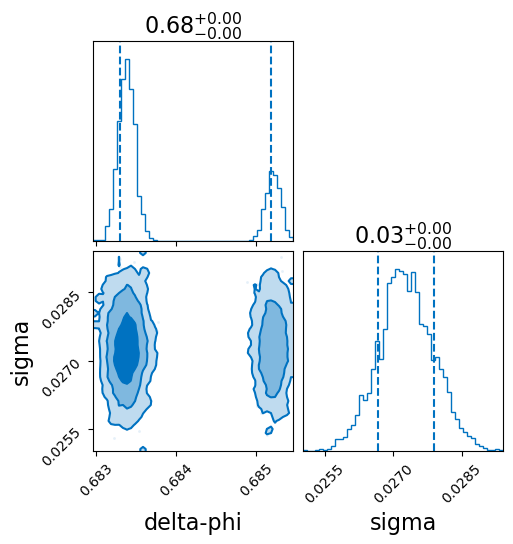

In [26]:
# plot a corner plot: all outputs are stored in outdir
result.plot_corner()

1.2.1
